In [1]:
from util import pixel_acc, iou
import matplotlib.pyplot as plt
import numpy as np
import torch
from voc import *

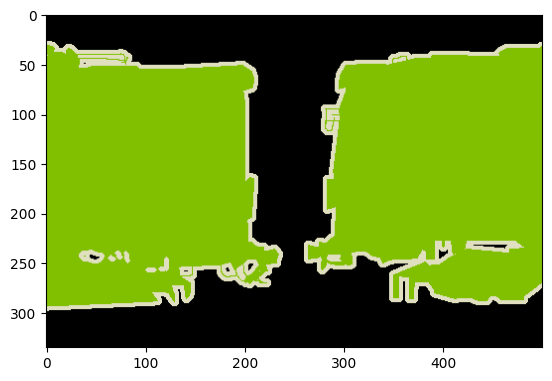

In [2]:
train = VOC('train')
t = train.imgs[2][1]

i = plt.imread(t)
plt.imshow(i)

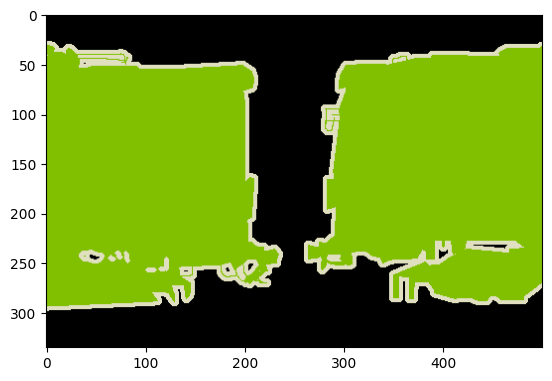

In [3]:
image_path = train.imgs[2][1]

image = plt.imread(image_path)
# image = (image * 255).astype(np.uint8)

plt.imshow(image)

In [4]:
image_boundaryremoved = image.copy()

boundary_color = [224, 224, 192, 255]  # Replace with the actual color values of your boundary

# Create a mask where the boundary color is present
boundary_mask = np.all(image_boundaryremoved == boundary_color, axis=-1)

# Set the color of all pixels in the mask to black
image_boundaryremoved[boundary_mask] = [0, 0, 0, 255]

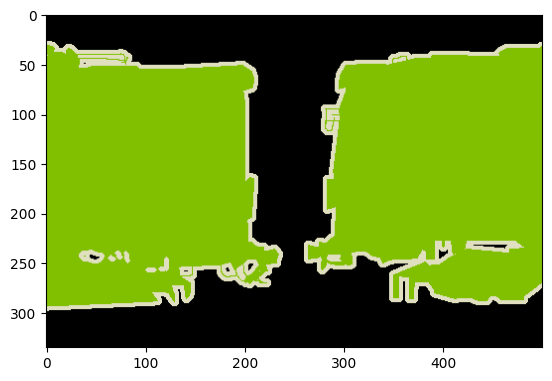

In [5]:
plt.imshow(image_boundaryremoved)

In [6]:
# make numpy arrays into torch tensors
image = torch.from_numpy(image)
image_boundaryremoved = torch.from_numpy(image_boundaryremoved)

In [7]:
pixel_acc(image, image_boundaryremoved)

RuntimeError: The size of tensor a (335) must match the size of tensor b (500) at non-singleton dimension 1

In [ ]:
iou(image, image_boundaryremoved)

RuntimeError: The size of tensor a (335) must match the size of tensor b (500) at non-singleton dimension 1

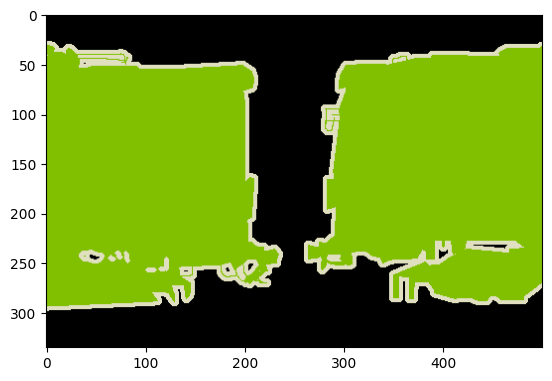

In [ ]:
# plt tensor images
plt.imshow(image)

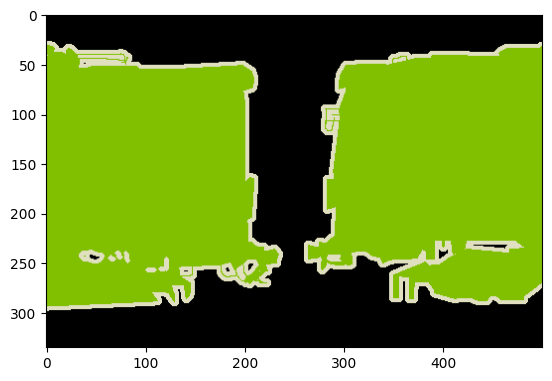

In [ ]:
plt.imshow(image_boundaryremoved)

In [ ]:
train = VOC('train')
test = VOC('test')

train_dataset = torch.utils.data.DataLoader(train, batch_size=1)
test_dataset = torch.utils.data.DataLoader(test, batch_size=1)

In [ ]:
palette_map = {
    0: [0, 0, 0], 1: [128, 0, 0], 2: [0, 128, 0], 3: [128, 128, 0], 4: [0, 0, 128], 5: [128, 0, 128], 6: [0, 128, 128],
    7: [128, 128, 128], 8: [64, 0, 0], 9: [192, 0, 0], 10: [64, 128, 0], 11: [192, 128, 0], 12: [64, 0, 128],
    13: [192, 0, 128], 14: [64, 128, 128], 15: [192, 128, 128], 16: [0, 64, 0], 17: [128, 64, 0], 18: [0, 192, 0],
    19: [128, 192, 0], 20: [0, 64, 128]
}

r_palette_map = {
    (0, 0, 0): 0, (128, 0, 0): 1, (0, 128, 0): 2, (128, 128, 0): 3, (0, 0, 128): 4, (128, 0, 128): 5, (0, 128, 128): 6,
    (128, 128, 128): 7, (64, 0, 0): 8, (192, 0, 0): 9, (64, 128, 0): 10, (192, 128, 0): 11, (64, 0, 128): 12,
    (192, 0, 128): 13, (64, 128, 128): 14, (192, 128, 128): 15, (0, 64, 0): 16, (128, 64, 0): 17, (0, 192, 0): 18,
    (128, 192, 0): 19, (0, 64, 128): 20
}

In [13]:
for _, label in train_dataset:
    print(label)
    break

TypeError: 'Image' object does not support item assignment

In [ ]:
def getClassWeights(dataset):
    total_pixels = 224 * 224 * len(dataset) # 224 * 224 is the size of the images
    class_weights = torch.zeros(21)
    for _,  label in dataset:
        class_weights += torch.bincount(label.view(-1), minlength=21)
    class_weights = class_weights / total_pixels
    class_weights /= class_weights.sum()
    return class_weights

In [14]:
import random
import torch
from torchvision.transforms import functional as F
from torchvision.transforms import InterpolationMode
from torchvision import transforms


class CommonTransforms:
    """
    A class that defines common image transformations.

    Args:
        size (tuple): The desired size of the transformed image. Default is (224, 224).

    """

    def __init__(self, size=(224, 224)):
        self.size = size

    def __call__(self, img, mask):
        """
        Applies common image transformations to the input image and mask.

        Args:
            img (PIL.Image.Image): The input image.
            mask (PIL.Image.Image): The input mask.

        Returns:
            tuple: A tuple containing the transformed image and mask.

        """
        # Random horizontal flip with the same decision for both img and mask
        if random.random() > 0.5:
            img = F.hflip(img)
            mask = F.hflip(mask)

        # Random resized crop with the same parameters for both img and mask
        i, j, h, w = transforms.RandomResizedCrop.get_params(img, scale=(0.08, 1.0), ratio=(3./4., 4./3.))
        img = F.resized_crop(img, i, j, h, w, self.size, InterpolationMode.BILINEAR)
        mask = F.resized_crop(mask, i, j, h, w, self.size, InterpolationMode.NEAREST)
        img = F.to_tensor(img)
        mask = F.to_tensor(mask)
        mask = mask.to(dtype=torch.int32).long()
        # Additional transformations can be added here with the same parameters for img and mask

        return img, mask

In [15]:
train = VOC('train', common_transform=CommonTransforms())

In [22]:
train[0][1].squeeze().shape

torch.Size([224, 224])

In [10]:
import torchvision.transforms as standard_transforms

class MaskToTensor(object):
    def __call__(self, img):
        return torch.from_numpy(np.array(img, dtype=np.int32)).long()

mean_std = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
input_transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(*mean_std)
    ])

target_transform = MaskToTensor()


In [12]:
val = VOC('val', transform=input_transform, target_transform=target_transform)


In [21]:
val[0][1].shape

torch.Size([224, 224])